In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *

2023-05-15 18:04:08.133835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 18:04:09.057289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-15 18:04:09.057430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-15 18:04:09.057435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
IMAGE_SHAPE = (5, 127, 127)
GB_LIMIT = 10

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 10000
LEARNING_RATE = 0.0001
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE
}

In [5]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5'

In [6]:
column_names = ['object_id', 'specz_redshift', 'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
with h5py.File(TRAIN_PATH, 'r') as hf:
    train_df = pd.DataFrame()
    for name in column_names:
        train_df[name] = hf[name][:]
    
with h5py.File(VAL_PATH, 'r') as hf:
    val_df = pd.DataFrame()
    for name in column_names:
        val_df[name] = hf[name][:]
    
with h5py.File(TEST_PATH, 'r') as hf:
    test_df = pd.DataFrame()
    for name in column_names:
        test_df[name] = hf[name][:]

In [7]:
mags = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
X_train, X_val, X_test = train_df[mags], val_df[mags], test_df[mags]
y_train, y_val, y_test = train_df['specz_redshift'], val_df['specz_redshift'], test_df['specz_redshift']
OID_train, OID_val, OID_test = train_df['object_id'], val_df['object_id'], test_df['object_id']

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [9]:
# for now, only run the NN architecture
# add callbacks

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_ = Input(shape=(5,))
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)
hidden5 = Dense(hparams['num_dense_units'], activation="relu")(hidden4)
hidden6 = Dense(hparams['num_dense_units'], activation="relu")(hidden5)
output = Dense(1)(hidden6)
model = Model(inputs=[input_], outputs=[output])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 200)               1200      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dense_5 (Dense)             (None, 200)               40200 

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_subnetwork_v1'

checkpoint_filepath = f'/data2/models/{model_name}/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
log_dir = os.path.join('/data2/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    verbose=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [ ]:
model.fit(X_train, y_train, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/10000
784/784 [==============================] - ETA: 0s - loss: 0.1926 - mse: 0.2004
Epoch 1: loss improved from inf to 0.19261, saving model to /data2/models/HSC_v6_NN_subnetwork_v1/checkpoints/cp.ckpt
784/784 [==============================] - 5s 4ms/step - loss: 0.1926 - mse: 0.2004 - val_loss: 0.1473 - val_mse: 0.1440
Epoch 2/10000
776/784 [============================>.] - ETA: 0s - loss: 0.1373 - mse: 0.1402
Epoch 2: loss improved from 0.19261 to 0.13720, saving model to /data2/models/HSC_v6_NN_subnetwork_v1/checkpoints/cp.ckpt
784/784 [==============================] - 3s 3ms/step - loss: 0.1372 - mse: 0.1402 - val_loss: 0.1312 - val_mse: 0.1326
Epoch 3/10000
771/784 [============================>.] - ETA: 0s - loss: 0.1295 - mse: 0.1343
Epoch 3: loss improved from 0.13720 to 0.12960, saving model to /data2/models/HSC_v6_NN_subnetwork_v1/checkpoints/cp.ckpt
784/784 [==============================] - 3s 3ms/step - loss: 0.1296 - mse: 0.1346 - val_loss: 0.1295 - val_mse: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



770/784 [============================>.] - ETA: 0s - loss: 0.0428 - mse: 0.0699
Epoch 2357: loss did not improve from 0.04190
784/784 [==============================] - 3s 4ms/step - loss: 0.0428 - mse: 0.0696 - val_loss: 0.1073 - val_mse: 0.1014
Epoch 2358/10000
781/784 [============================>.] - ETA: 0s - loss: 0.0423 - mse: 0.0693
Epoch 2358: loss did not improve from 0.04190
784/784 [==============================] - 3s 4ms/step - loss: 0.0423 - mse: 0.0693 - val_loss: 0.1073 - val_mse: 0.1028
Epoch 2359/10000
780/784 [============================>.] - ETA: 0s - loss: 0.0421 - mse: 0.0690
Epoch 2359: loss did not improve from 0.04190
784/784 [==============================] - 3s 4ms/step - loss: 0.0421 - mse: 0.0692 - val_loss: 0.1080 - val_mse: 0.1016
Epoch 2360/10000
777/784 [============================>.] - ETA: 0s - loss: 0.0423 - mse: 0.0696
Epoch 2360: loss did not improve from 0.04190
784/784 [==============================] - 3s 4ms/step - loss: 0.0423 - mse: 0.069

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



769/784 [============================>.] - ETA: 0s - loss: 0.0417 - mse: 0.0686
Epoch 2432: loss did not improve from 0.04130
784/784 [==============================] - 3s 3ms/step - loss: 0.0418 - mse: 0.0687 - val_loss: 0.1087 - val_mse: 0.1014
Epoch 2433/10000
773/784 [============================>.] - ETA: 0s - loss: 0.0417 - mse: 0.0685
Epoch 2433: loss did not improve from 0.04130
784/784 [==============================] - 3s 4ms/step - loss: 0.0417 - mse: 0.0688 - val_loss: 0.1079 - val_mse: 0.1025
Epoch 2434/10000
776/784 [============================>.] - ETA: 0s - loss: 0.0421 - mse: 0.0692
Epoch 2434: loss did not improve from 0.04130
784/784 [==============================] - 3s 4ms/step - loss: 0.0421 - mse: 0.0690 - val_loss: 0.1076 - val_mse: 0.1011
Epoch 2435/10000
783/784 [============================>.] - ETA: 0s - loss: 0.0422 - mse: 0.0691
Epoch 2435: loss did not improve from 0.04130
784/784 [==============================] - 3s 4ms/step - loss: 0.0422 - mse: 0.069

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



781/784 [============================>.] - ETA: 0s - loss: 0.0379 - mse: 0.0655
Epoch 3150: loss improved from 0.03795 to 0.03795, saving model to /data2/models/HSC_v6_NN_subnetwork_v1/checkpoints/cp.ckpt
784/784 [==============================] - 3s 4ms/step - loss: 0.0379 - mse: 0.0654 - val_loss: 0.1124 - val_mse: 0.1019
Epoch 3151/10000
784/784 [==============================] - ETA: 0s - loss: 0.0384 - mse: 0.0655
Epoch 3151: loss did not improve from 0.03795
784/784 [==============================] - 3s 4ms/step - loss: 0.0384 - mse: 0.0655 - val_loss: 0.1115 - val_mse: 0.1029
Epoch 3152/10000
772/784 [============================>.] - ETA: 0s - loss: 0.0388 - mse: 0.0655
Epoch 3152: loss did not improve from 0.03795
784/784 [==============================] - 3s 4ms/step - loss: 0.0387 - mse: 0.0656 - val_loss: 0.1112 - val_mse: 0.1023
Epoch 3153/10000
770/784 [============================>.] - ETA: 0s - loss: 0.0381 - mse: 0.0652
Epoch 3153: loss did not improve from 0.03795
784

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



777/784 [============================>.] - ETA: 0s - loss: 0.0368 - mse: 0.0643
Epoch 3498: loss did not improve from 0.03668
784/784 [==============================] - 3s 4ms/step - loss: 0.0368 - mse: 0.0642 - val_loss: 0.1129 - val_mse: 0.1019
Epoch 3499/10000
776/784 [============================>.] - ETA: 0s - loss: 0.0370 - mse: 0.0641
Epoch 3499: loss did not improve from 0.03668
784/784 [==============================] - 3s 4ms/step - loss: 0.0371 - mse: 0.0643 - val_loss: 0.1125 - val_mse: 0.1027
Epoch 3500/10000
771/784 [============================>.] - ETA: 0s - loss: 0.0370 - mse: 0.0644
Epoch 3500: loss did not improve from 0.03668
784/784 [==============================] - 3s 4ms/step - loss: 0.0370 - mse: 0.0642 - val_loss: 0.1126 - val_mse: 0.1017
Epoch 3501/10000
775/784 [============================>.] - ETA: 0s - loss: 0.0368 - mse: 0.0642
Epoch 3501: loss did not improve from 0.03668
784/784 [==============================] - 3s 4ms/step - loss: 0.0369 - mse: 0.064

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



781/784 [============================>.] - ETA: 0s - loss: 0.0362 - mse: 0.0631
Epoch 3844: loss did not improve from 0.03567
784/784 [==============================] - 3s 4ms/step - loss: 0.0362 - mse: 0.0631 - val_loss: 0.1147 - val_mse: 0.1020
Epoch 3845/10000
780/784 [============================>.] - ETA: 0s - loss: 0.0363 - mse: 0.0632
Epoch 3845: loss did not improve from 0.03567
784/784 [==============================] - 3s 4ms/step - loss: 0.0363 - mse: 0.0632 - val_loss: 0.1139 - val_mse: 0.1019
Epoch 3846/10000
783/784 [============================>.] - ETA: 0s - loss: 0.0359 - mse: 0.0630
Epoch 3846: loss did not improve from 0.03567
784/784 [==============================] - 3s 4ms/step - loss: 0.0359 - mse: 0.0630 - val_loss: 0.1141 - val_mse: 0.1021
Epoch 3847/10000
768/784 [============================>.] - ETA: 0s - loss: 0.0360 - mse: 0.0632
Epoch 3847: loss did not improve from 0.03567
784/784 [==============================] - 3s 3ms/step - loss: 0.0360 - mse: 0.063

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



772/784 [============================>.] - ETA: 0s - loss: 0.0348 - mse: 0.0618
Epoch 4246: loss did not improve from 0.03436
784/784 [==============================] - 3s 3ms/step - loss: 0.0348 - mse: 0.0618 - val_loss: 0.1151 - val_mse: 0.1035
Epoch 4247/10000
771/784 [============================>.] - ETA: 0s - loss: 0.0349 - mse: 0.0618
Epoch 4247: loss did not improve from 0.03436
784/784 [==============================] - 3s 3ms/step - loss: 0.0349 - mse: 0.0618 - val_loss: 0.1152 - val_mse: 0.1033
Epoch 4248/10000
777/784 [============================>.] - ETA: 0s - loss: 0.0351 - mse: 0.0619
Epoch 4248: loss did not improve from 0.03436
784/784 [==============================] - 3s 3ms/step - loss: 0.0351 - mse: 0.0618 - val_loss: 0.1156 - val_mse: 0.1041
Epoch 4249/10000
777/784 [============================>.] - ETA: 0s - loss: 0.0348 - mse: 0.0618
Epoch 4249: loss did not improve from 0.03436
784/784 [==============================] - 3s 3ms/step - loss: 0.0349 - mse: 0.061

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



783/784 [============================>.] - ETA: 0s - loss: 0.0341 - mse: 0.0609
Epoch 4543: loss did not improve from 0.03370
784/784 [==============================] - 5s 7ms/step - loss: 0.0341 - mse: 0.0608 - val_loss: 0.1174 - val_mse: 0.1026
Epoch 4544/10000
776/784 [============================>.] - ETA: 0s - loss: 0.0341 - mse: 0.0610
Epoch 4544: loss did not improve from 0.03370
784/784 [==============================] - 5s 7ms/step - loss: 0.0341 - mse: 0.0609 - val_loss: 0.1165 - val_mse: 0.1026
Epoch 4545/10000
784/784 [==============================] - ETA: 0s - loss: 0.0341 - mse: 0.0610
Epoch 4545: loss did not improve from 0.03370
784/784 [==============================] - 5s 7ms/step - loss: 0.0341 - mse: 0.0610 - val_loss: 0.1165 - val_mse: 0.1021
Epoch 4546/10000
777/784 [============================>.] - ETA: 0s - loss: 0.0344 - mse: 0.0608
Epoch 4546: loss did not improve from 0.03370
784/784 [==============================] - 5s 7ms/step - loss: 0.0344 - mse: 0.060

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



782/784 [============================>.] - ETA: 0s - loss: 0.0331 - mse: 0.0597
Epoch 4950: loss did not improve from 0.03299
784/784 [==============================] - 3s 3ms/step - loss: 0.0331 - mse: 0.0597 - val_loss: 0.1179 - val_mse: 0.1023
Epoch 4951/10000
771/784 [============================>.] - ETA: 0s - loss: 0.0335 - mse: 0.0598
Epoch 4951: loss did not improve from 0.03299
784/784 [==============================] - 3s 3ms/step - loss: 0.0336 - mse: 0.0599 - val_loss: 0.1187 - val_mse: 0.1047
Epoch 4952/10000
784/784 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0574
Epoch 5853: loss did not improve from 0.03131
784/784 [==============================] - 3s 4ms/step - loss: 0.0316 - mse: 0.0574 - val_loss: 0.1202 - val_mse: 0.1044
Epoch 5854/10000
783/784 [============================>.] - ETA: 0s - loss: 0.0316 - mse: 0.0576
Epoch 5854: loss did not improve from 0.03131
784/784 [==============================] - 3s 3ms/step - loss: 0.0316 - mse: 0.057

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



775/784 [============================>.] - ETA: 0s - loss: 0.0311 - mse: 0.0572
Epoch 5920: loss improved from 0.03115 to 0.03111, saving model to /data2/models/HSC_v6_NN_subnetwork_v1/checkpoints/cp.ckpt
784/784 [==============================] - 3s 3ms/step - loss: 0.0311 - mse: 0.0572 - val_loss: 0.1200 - val_mse: 0.1041
Epoch 5921/10000
778/784 [============================>.] - ETA: 0s - loss: 0.0321 - mse: 0.0574
Epoch 5921: loss did not improve from 0.03111
784/784 [==============================] - 3s 3ms/step - loss: 0.0321 - mse: 0.0575 - val_loss: 0.1208 - val_mse: 0.1036
Epoch 5922/10000
770/784 [============================>.] - ETA: 0s - loss: 0.0320 - mse: 0.0572
Epoch 5922: loss did not improve from 0.03111
784/784 [==============================] - 3s 3ms/step - loss: 0.0320 - mse: 0.0573 - val_loss: 0.1205 - val_mse: 0.1042
Epoch 5923/10000
770/784 [============================>.] - ETA: 0s - loss: 0.0310 - mse: 0.0573
Epoch 5923: loss improved from 0.03111 to 0.03095

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



774/784 [============================>.] - ETA: 0s - loss: 0.0293 - mse: 0.0540
Epoch 7611: loss did not improve from 0.02870
784/784 [==============================] - 3s 3ms/step - loss: 0.0292 - mse: 0.0539 - val_loss: 0.1233 - val_mse: 0.1043
Epoch 7612/10000
771/784 [============================>.] - ETA: 0s - loss: 0.0290 - mse: 0.0538
Epoch 7612: loss did not improve from 0.02870
784/784 [==============================] - 2s 3ms/step - loss: 0.0290 - mse: 0.0539 - val_loss: 0.1238 - val_mse: 0.1046
Epoch 7613/10000
780/784 [============================>.] - ETA: 0s - loss: 0.0291 - mse: 0.0538
Epoch 7613: loss did not improve from 0.02870
784/784 [==============================] - 2s 3ms/step - loss: 0.0291 - mse: 0.0539 - val_loss: 0.1233 - val_mse: 0.1042
Epoch 7614/10000
770/784 [============================>.] - ETA: 0s - loss: 0.0289 - mse: 0.0539
Epoch 7614: loss did not improve from 0.02870
784/784 [==============================] - 3s 3ms/step - loss: 0.0288 - mse: 0.053

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



777/784 [============================>.] - ETA: 0s - loss: 0.0288 - mse: 0.0536
Epoch 7799: loss did not improve from 0.02835
784/784 [==============================] - 2s 3ms/step - loss: 0.0288 - mse: 0.0535 - val_loss: 0.1241 - val_mse: 0.1046
Epoch 7800/10000
766/784 [============================>.] - ETA: 0s - loss: 0.0289 - mse: 0.0534
Epoch 7800: loss did not improve from 0.02835
784/784 [==============================] - 2s 3ms/step - loss: 0.0289 - mse: 0.0536 - val_loss: 0.1232 - val_mse: 0.1041
Epoch 7801/10000
776/784 [============================>.] - ETA: 0s - loss: 0.0286 - mse: 0.0533
Epoch 7801: loss did not improve from 0.02835
784/784 [==============================] - 2s 3ms/step - loss: 0.0286 - mse: 0.0534 - val_loss: 0.1235 - val_mse: 0.1044
Epoch 7802/10000
778/784 [============================>.] - ETA: 0s - loss: 0.0294 - mse: 0.0539
Epoch 7802: loss did not improve from 0.02835
784/784 [==============================] - 3s 3ms/step - loss: 0.0293 - mse: 0.053

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



777/784 [============================>.] - ETA: 0s - loss: 0.0289 - mse: 0.0535
Epoch 7903: loss did not improve from 0.02827
784/784 [==============================] - 3s 3ms/step - loss: 0.0289 - mse: 0.0535 - val_loss: 0.1238 - val_mse: 0.1040
Epoch 7904/10000
780/784 [============================>.] - ETA: 0s - loss: 0.0285 - mse: 0.0534
Epoch 7904: loss did not improve from 0.02827
784/784 [==============================] - 3s 3ms/step - loss: 0.0285 - mse: 0.0533 - val_loss: 0.1239 - val_mse: 0.1041
Epoch 7905/10000
769/784 [============================>.] - ETA: 0s - loss: 0.0286 - mse: 0.0533
Epoch 7905: loss did not improve from 0.02827
784/784 [==============================] - 3s 3ms/step - loss: 0.0286 - mse: 0.0532 - val_loss: 0.1242 - val_mse: 0.1050
Epoch 7906/10000
784/784 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0533
Epoch 7906: loss did not improve from 0.02827
784/784 [==============================] - 3s 3ms/step - loss: 0.0289 - mse: 0.053

In [ ]:
# kernel crashed but the loss wasn't improving for several epochs so we'll use this

In [15]:
model.load_weights(checkpoint_filepath)

In [16]:
pred = model.predict(X_test)

1343/1343 [==============================] - 2s 954us/step


In [17]:
y_pred = np.ravel(pred) # to make ndim = 1
y_pred

array([0.26057532, 0.23321655, 0.53189796, ..., 0.65382874, 2.277929  ,
       0.9879306 ], dtype=float32)

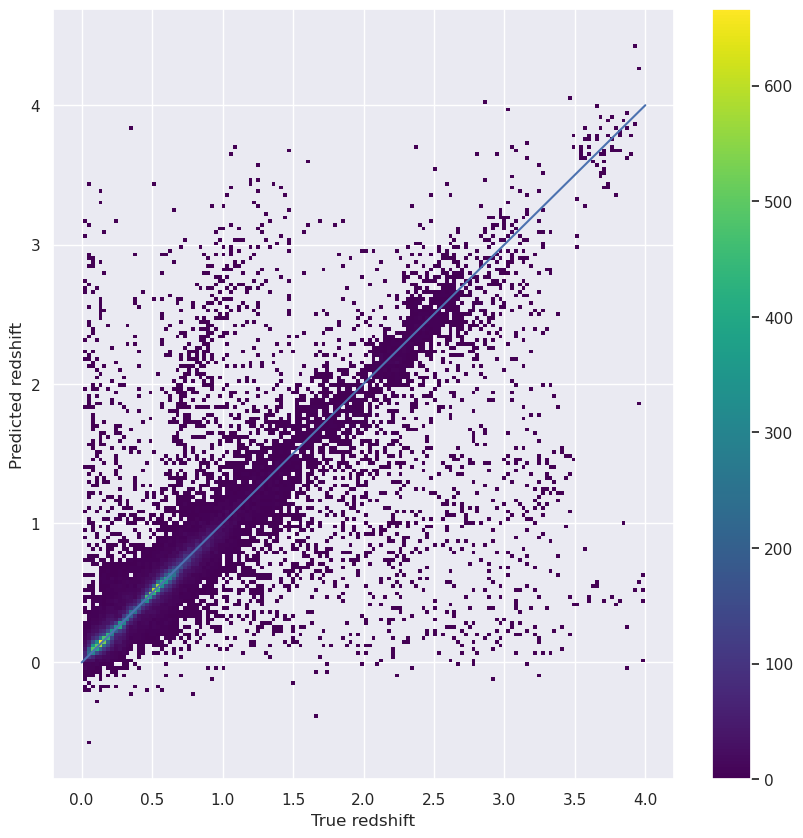

In [18]:
plot_predictions(y_pred, y_test)

In [19]:
metrics = get_point_metrics(pd.Series(y_pred), pd.Series(y_test))

In [20]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",42960,0.124483,-0.001322,-0.000883,0.042308,0.033881,0.161802,0.083776,0.10504


In [22]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(OID_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)

In [23]:
y_train

0         2.17865
1         0.84550
2         0.44850
3         0.37001
4         0.58149
           ...   
200476    1.86393
200477    0.89864
200478    0.24194
200479    0.77584
200480    1.06695
Name: specz_redshift, Length: 200481, dtype: float64